SISTEMA DE RECOMENDAÇÃO BASEADO EM AVALIAÇÕES DE FILMES

Os dados utilizados nesse trabalho são compostos de 100.000 avaliações de 1 a 5 feitas por 943 usuários a partir de 1682 filmes. Cada usuário avaliou pelo menos 20 filmes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
datam = pd.read_csv('movies.CSV', sep=';', encoding='unicode_escape', decimal=",")
datam

,UserId,ItemId,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [3]:
#Como a coluna "Timestamp" não será utilizada
datam=datam.drop(columns=['Timestamp'])

In [4]:
datam.shape

(100000, 3)

In [5]:
datam.UserId = datam.UserId.astype('category')
datam.ItemId = datam.ItemId.astype('category')

In [6]:
datam.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   UserId  100000 non-null  category
 1   ItemId  100000 non-null  category
 2   Rating  100000 non-null  int64   
dtypes: category(2), int64(1)
memory usage: 1.3 MB


In [7]:
datam.describe(include='all')

,UserId,ItemId,Rating
count,100000.0,100000.0,100000.000000
unique,943.0,1682.0,NaN
top,405.0,50.0,NaN
freq,737.0,583.0,NaN
mean,NaN,NaN,3.529860
std,NaN,NaN,1.125674
min,NaN,NaN,1.000000
25%,NaN,NaN,3.000000
50%,NaN,NaN,4.000000
75%,NaN,NaN,4.000000


O usuário que mais fez avaliações foi o "405", 737 vezes.
O filme mais avaliado foi o "50", 583 vezes.
A média das avaliações é de 3.52, o que mostra uma inclinação para avaliações positivas.
O desvio padrão é de 1.12, ou seja, há um intervalo de 2 a 4 para a maioria das avaliações.

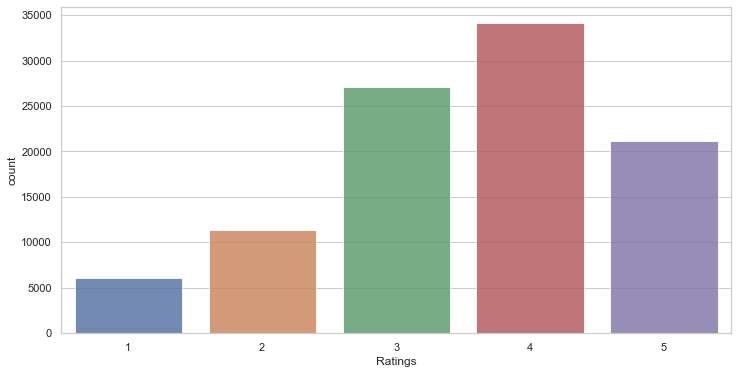

In [8]:
# Histograma
plt.figure(figsize=(12,6))
sns.countplot(x='Rating', data=datam, alpha=0.85)
plt.xlabel('Ratings', size=12)
plt.show()

In [9]:
print(f'Número total de avaliações: {len(datam)} \nNúmero total de usuários: {len(datam.UserId.unique())} \
\nNúmero médio de avaliações por usuário: {round(len(datam)/len(datam.UserId.unique()),2)}')

Número total de avaliações: 100000 
Número total de usuários: 943 
Número médio de avaliações por usuário: 106.04


No entanto, sabe-se que a distribuição não é tão homogênea, já que há alguns usuários que avaliam centenas de produtos, enquanto que outros avaliam pouquíssimos.
Com isso, deve-se separar os usuários mais ativos:

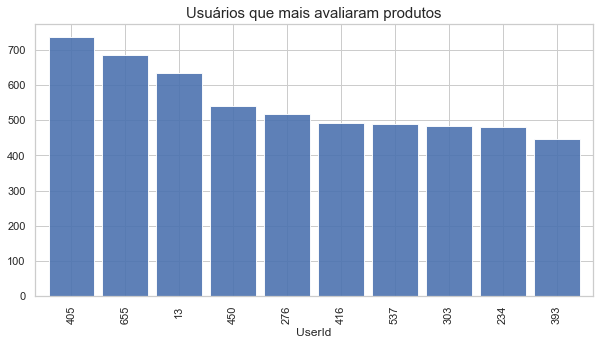

In [10]:
more = datam.groupby('UserId').Rating.count().sort_values(ascending=False)
plt.figure(figsize=(10,5))
more.head(10).plot(kind='bar', alpha=0.9, width=0.85)
plt.title("Usuários que mais avaliaram produtos", size=15)
plt.show()

RECOMENDAÇÃO BASEADA EM POPULARIDADE

- O sistema de recomendação mais simples.
- Calcula a quantidade de avaliações e a média de cada item e cria um ranking.
- Não permite personalização.


In [11]:
#Dataframe de filmes com mais de 50 avaliações
new_df=datam.groupby("ItemId").filter(lambda x:x['Rating'].count() >=50)
new_df.head()

,UserId,ItemId,Rating
0,196,242,3
1,186,302,3
3,244,51,2
4,166,346,1
5,298,474,4


In [12]:
#Dataframe com a média e o número de avaliações por produto
ratings_df = pd.DataFrame(new_df.groupby('ItemId').Rating.mean())
ratings_df.dropna(inplace=True)

In [13]:
# Adiciona coluna com número de avaliações por produto
ratings_df['Rating_counts'] = new_df.groupby('ItemId').Rating.count()

In [14]:
# Top 5 produtos mais avaliados
ratings_df.sort_values(by='Rating_counts', ascending=False).head()

,Rating,Rating_counts
ItemId,,
50,4.358491,583
258,3.803536,509
100,4.155512,508
181,4.007890,507
294,3.156701,485


In [15]:
ratings_df

,Rating,Rating_counts
ItemId,,
1,3.878319,452
2,3.206107,131
3,3.033333,90
4,3.550239,209
5,3.302326,86
...,...,...
1065,3.490566,53
1073,3.818182,66
1074,2.961039,77


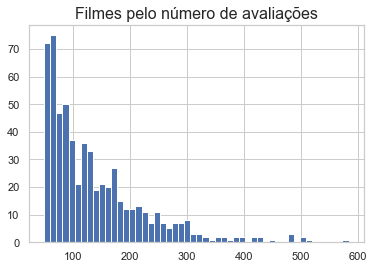

In [16]:

ratings_df.Rating_counts.hist(bins=50)
plt.title('Filmes pelo número de avaliações', size=16)
plt.show()

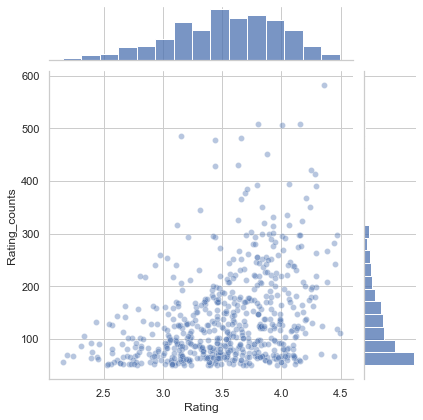

In [17]:
sns.jointplot(x='Rating', y='Rating_counts', data=ratings_df, alpha=0.4)
plt.show()

Percebe-se novamente a concentração de avaliações entre 3 e 4.

Tendo como base que o número mínimo de recomendações para que um filme seja considerado polular é de 50 avaliações, pode-se calcular a média global e posteriormente a média ponderada. Com isso utiliza-se a métrica utilizada pelo IMDB, tendo como base o numéro total de opiniões e o limite de 50, os quais são multiplicados pela média global e pela média dos filmes. Pode-se escrever a fórmmula como: (v/(v+m) R) + (m/(m+v) C).

- v : número de avaliações por filme;
- m : valor mínimo de votos para se estar na lista;
- R : média de avaliações por filme;
- C ; a média de votos total. the mean vote across the whole report

In [18]:
#Média Global
C = ratings_df['Rating'].mean()
print(round(C,2))

3.53


In [19]:
#Número mínimo de votos para garantir a recomendação de popularidade
m = ratings_df.Rating_counts.min(); m

50

In [20]:
# Função que calcula a média ponderada de cada filme
def ponderada(x, m=m, C=C):
    v = x['Rating_counts']
    R = x['Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [21]:
# Adiciona o score de cada filme ao dataframe
ratings_df['score'] = ratings_df.apply(ponderada, axis=1)

In [22]:
ratings_df

,Rating,Rating_counts,score
ItemId,,,
1,3.878319,452,3.843484
2,3.206107,131,3.295188
3,3.033333,90,3.210207
4,3.550239,209,3.546058
5,3.302326,86,3.385507
...,...,...,...
1065,3.490566,53,3.509019
1073,3.818182,66,3.693353
1074,2.961039,77,3.184480


In [23]:
# Resultado: 15 filmes mais populares. 
# Pode-se observar que o filme mais avaliado não é o que tem um maior score, ocupando apenas a quarta posição.
ratings_df.sort_values(by='score', ascending=False).head(15)

,Rating,Rating_counts,score
ItemId,,,
318,4.466443,298,4.331693
64,4.445230,283,4.307595
483,4.456790,243,4.298392
50,4.358491,583,4.292937
12,4.385768,267,4.250565
603,4.387560,209,4.221734
98,4.289744,390,4.203248
127,4.283293,413,4.201790
408,4.491071,112,4.194006


FILTRAGEM COLABORATIVA

Partindo do pressuposto de que pessoas que pensam da mesma forma parecidas tendem a dar notas semelhantes e produtos semelhantes tendem a receber notas semelhantes, pode-se recomendar filmes e até prever as notas que faltam de outro usuário semelhante. Também deve-se levar em consideração o fato de que normalmente uma pessoa não avalia todos os produtos.
Dessa forma, o intuito é transformar as avaliações positivas e negativas de cada pessoa em vetores de números e comparar o ângulo entre eles. Quanto menor o ângulo, mais afinidades eles tem,e quanto maior o ângulo, eles tendem a ser mais diferentes.

In [24]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD

In [25]:

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [26]:
#Divisão dos dados 70% / 30%
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [27]:
# Criação de um modelo baseado em item (user_based true / false para alternar entre filtragem colaborativa baseada em usuário ou baseada em item)
algo = KNNWithMeans(k=5, sim_options={'user_based': False})
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [28]:
#Teste do modelo
test_pred = algo.test(testset)

In [29]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.9731


0.9731304938258023

In [30]:
#Função get_neighbors para obter as 10 recomendações para o Filme no índice 1 de ratings_df
recomendados = algo.get_neighbors(1, 10)
recomendados 

[546, 117, 306, 430, 239, 462, 508, 522, 554, 579]

In [31]:
#Os 10 filmes recomendados
ratings_df.iloc[[546, 117, 306, 430, 239, 462, 508, 522, 554, 579]].index

CategoricalIndex([815, 144, 384, 558, 280, 632, 715, 740, 845, 939], categories=[1, 2, 3, 4, 5, 6, 7, 8, ...], ordered=False, dtype='category', name='ItemId')

SISTEMA DE FATORAÇÃO DE MATRIZ (algoritmo SVD)

O modelo Matrix Factorization (SVD) leva em consideração o nome do usuário e id do produto para fazer as previsões.

In [32]:
#Criação de uma matriz esparsa com os dados
#50 mil linhas por motivo de uso computacional
new_df1=new_df.head(50000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='UserId', columns='ItemId', fill_value=0)
ratings_matrix.head()

ItemId,1,2,3,4,5,7,8,9,10,11,...,1035,1039,1041,1047,1048,1065,1073,1074,1101,1119
UserId,,,,,,,,,,,,,,,,,,,,,
1,5,3,0,0,3,0,1,5,3,2,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
ratings_matrix.shape

(870, 603)

In [34]:
#Gera matriz transposta
X = ratings_matrix.T
X

UserId,1,2,3,4,5,6,7,8,9,10,...,864,865,866,867,868,870,871,872,875,876
ItemId,,,,,,,,,,,,,,,,,,,,,
1,5,4,0,0,4,4,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,5,0,0,4,...,0,0,0,0,0,0,0,0,0,0
5,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
X.shape

(603, 870)

In [36]:
#Decompondo a matriz
#A função vai reduzir a dimensão da matriz esparsa para o número de componentes solicitados
SVD_model = TruncatedSVD(n_components=10)
decomposed_matrix = SVD_model.fit_transform(X)
decomposed_matrix.shape

(603, 10)

In [37]:
#Matriz de correlação
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(603, 603)

Criou-se uma matriz de correlação a partir da matriz decomposta, calculando quanto um usuário é similar ao outro. Ou seja, cada usuário vai ser comparado individualmente aos outros, quanto mais próximo a 1, serão mais parecidos, e mais próximo de -1, mais diferente. 

In [38]:
correlation_matrix


array([[1.        , 0.61478635, 0.5838425 , ..., 0.58967933, 0.58379029,
        0.66369637],
       [0.61478635, 1.        , 0.76262219, ..., 0.67031258, 0.48928903,
        0.64553468],
       [0.5838425 , 0.76262219, 1.        , ..., 0.81571277, 0.42799258,
        0.64535953],
       ...,
       [0.58967933, 0.67031258, 0.81571277, ..., 1.        , 0.49945147,
        0.91896164],
       [0.58379029, 0.48928903, 0.42799258, ..., 0.49945147, 1.        ,
        0.62309149],
       [0.66369637, 0.64553468, 0.64535953, ..., 0.91896164, 0.62309149,
        1.        ]])

In [39]:
#Foi escolhido o mesmo filme da recomendação "Item-based"
i = 2
Movie_names = list(X.index)
Item_ID = Movie_names.index(i)
Item_ID

1

In [40]:
#Correlação para todos os filmes comparado ao filme assistido por este usuário
correlation_Item_ID = correlation_matrix[Item_ID]
correlation_Item_ID.shape

(603,)

In [41]:
# Os 10 filmes mais parecidos para esse usuário. 
Recommend = list(X.index[correlation_Item_ID > 0.65])

#remove o filme que está sendo utilizado como base
Recommend.remove(i) 

Recommend[0:10]

[3, 4, 5, 7, 8, 11, 12, 17, 21, 22]

In [42]:
item_based = [815, 144, 384, 558, 280, 632, 715, 740, 845, 939]
SVD_model_res =[3, 4, 5, 7, 8, 11, 12, 17, 21, 22]
c = 0
for i in item_based:
    if i in SVD_model_res:
        c +=1

c

0

SVD

In [43]:
from surprise import SVD
from surprise.model_selection import cross_validate, KFold

In [44]:
model_matrix = SVD()

In [45]:
model_matrix_results = cross_validate(model_matrix, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9183  0.9220  0.9200  0.9203  0.9273  0.9216  0.0031  
Fit time          4.49    4.23    4.35    4.36    4.34    4.35    0.08    
Test time         0.17    0.11    0.12    0.13    0.09    0.12    0.03    


In [51]:
def get_top_n(predictions, n=5):
   
    #mapeando os resultados para cada usuário
    top_n = dict()
    for uid, iid, true_r, est, _ in predictions:
        current = top_n.get(uid, [])
        current.append((iid, est))
        top_n[uid] = current

    #Ordenando os resultados para cada usuário
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [53]:
models = [model_matrix, algo]
model_names = ['Matrix Factorization', 'Item-Based']

for i, model in enumerate(models):
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)
    # Print one line
    user = list(top_n.keys())[14]
    print('* ' *10)
    print(f'Nome do Modelo: {model_names[i]}')
    print(f'ID do usuário: {user}')
    print(f'Os 5 produtos que o usuário pode gostar, ordenados de maior a menor nota: {top_n[user]}')

* * * * * * * * * * 
Nome do Modelo: Matrix Factorization
ID do usuário: 747
Os 5 produtos que o usuário pode gostar, ordenados de maior a menor nota: [(174, 4.885467005596282), (285, 4.861723283613199), (408, 4.8072705957693564), (169, 4.777628965295182), (98, 4.714973953040406)]
Computing the msd similarity matrix...
Done computing similarity matrix.
* * * * * * * * * * 
Nome do Modelo: Item-Based
ID do usuário: 747
Os 5 produtos que o usuário pode gostar, ordenados de maior a menor nota: [(488, 5), (169, 5), (183, 5), (531, 5), (178, 5)]
